In [82]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import word2vec
import matplotlib.pyplot as plt

%matplotlib inline
import umap

import warnings
warnings.filterwarnings('ignore')


# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier


## PART1 - Data Cleaning & Exploratory Data Analysis & Visualization

#### Loading the Dataset

In [83]:
def product_view_based_data():
  products = pd.read_csv("products.csv",index_col=[0])
  products.columns = ['Client','Timestamp','ProductId'] # renaming columns
    
  data = products.copy() ## to protect previous version

  return data

In [84]:
product_view_data = product_view_based_data()
product_view_data.head()

,Client,Timestamp,ProductId
208,85ab8f53-b934-49dd-8d54-479ed08499f6,2021-08-29 17:05:45.368000+00:00,63594
209,85ab8f53-b934-49dd-8d54-479ed08499f6,2021-08-29 17:07:02.711000+00:00,63290
210,85ab8f53-b934-49dd-8d54-479ed08499f6,2021-08-29 17:08:51.306000+00:00,64872
247,46989f50-87f9-4ece-9db3-cffaa3bf2278,2021-08-29 19:23:07.176000+00:00,63593
1665,dbbcd1c1-c0ca-4eed-b144-736fc40f6d24,2021-08-29 20:00:40.706000+00:00,56093


In [85]:
product_view_data.tail()

,Client,Timestamp,ProductId
17004826,8776db01-284d-435d-8a59-33cb75d8bf63,2021-09-14 16:17:36.304000+00:00,615292687
17004827,8776db01-284d-435d-8a59-33cb75d8bf63,2021-09-14 16:26:08.205000+00:00,113877068
17004886,5c48ff59-358d-4b7d-823d-21ce7b4b7d3b,2021-09-14 20:13:18.263000+00:00,745895506
17004950,e522131c-c63a-476e-b9c2-d2c9e25b3956,2021-09-14 10:15:28.010000+00:00,350993703
17005068,397f7431-3eba-4fff-acd3-818a64e5e26b,2021-09-14 10:19:12.904000+00:00,599284204


### Structured Information of Dataset

In [86]:
print("Shape: %s" % str(product_view_data.shape))
print("Column names: %s" % str(product_view_data.columns))

Shape: (323614, 3)
Column names: Index(['Client', 'Timestamp', 'ProductId'], dtype='object')


In [87]:
product_view_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323614 entries, 208 to 17005068
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Client     323614 non-null  object
 1   Timestamp  323614 non-null  object
 2   ProductId  323614 non-null  object
dtypes: object(3)
memory usage: 9.9+ MB


In [88]:
product_view_data.describe().T

,count,unique,top,freq
Client,323614,27799,83171363-2d52-4e96-be88-0e902ebf6055,15
Timestamp,323614,323573,2021-09-11 23:03:51.562000+00:00,2
ProductId,323614,83622,752126531,581


### Sort the dataframe by 'Timestamp' in Descending order

In [89]:
product_view_data_sorted = product_view_data.sort_values(by = 'Timestamp', ascending = False) 
product_view_data_sorted.head(10)

,Client,Timestamp,ProductId
12816843,c34f7696-1b94-4b90-85e3-55bddb0736ff,2021-09-19 20:59:51.447000+00:00,330910959
14039649,c34f7696-1b94-4b90-85e3-55bddb0736ff,2021-09-19 20:59:22.723000+00:00,a704117540
9490286,a46cd409-8c53-4434-99c4-cdb81b673219,2021-09-19 20:59:12.794000+00:00,88123936
16484288,aca66064-3e9d-4567-9346-538a4d835d89,2021-09-19 20:59:09.392000+00:00,a168531398
15589460,71258f55-c310-4825-ac0c-f60e4b68a8cc,2021-09-19 20:58:56.350000+00:00,a618220837
14039648,c34f7696-1b94-4b90-85e3-55bddb0736ff,2021-09-19 20:58:40.237000+00:00,647190730
10367291,aca66064-3e9d-4567-9346-538a4d835d89,2021-09-19 20:58:36.773000+00:00,711495426
7918966,314f66b9-9155-4ab4-8c37-531e0098ecd9,2021-09-19 20:58:21.346000+00:00,a775993387
15589459,71258f55-c310-4825-ac0c-f60e4b68a8cc,2021-09-19 20:58:18.187000+00:00,a618220837
7923941,c34f7696-1b94-4b90-85e3-55bddb0736ff,2021-09-19 20:58:17.373000+00:00,605330268


### Analyze of Missing Values

In [90]:
product_view_data_sorted.isnull().values.any()  # Is There any missing value?

False

### Unique Clients and Products

In [121]:
## veri setindeki benzersiz müşteri sayısını kontrol eder
print("Unique Client count: %s" % str(product_view_data_sorted.Client.nunique()))
print("Unique ProductID count: %s" % str(product_view_data_sorted.ProductId.nunique()))

Unique Client count: 27799
Unique ProductID count: 83622


### Count of the number of Client per ProductId

In [92]:
client_rating_count = product_view_data_sorted.groupby('Client')['ProductId'].count()
client_rating_count.tail()

Client
fff8924d-cee8-43ae-a40a-8d398d912821    14
fffc2c60-bee1-4df9-8d3b-678e53c16849    14
fffc847c-3e99-42eb-b197-067d6dd001d0    11
ffffb04e-90e4-4321-b5e1-44071d2a9310    10
ffffded9-2ab0-4294-83a0-a047ca9355d9    13
Name: ProductId, dtype: int64

### Count of the number of ProductId per Client

In [93]:
product_rating_count = product_view_data_sorted.groupby('ProductId')['Client'].count()
product_rating_count.tail()

ProductId
a97507228    2
a982         1
a984         1
a99991095    1
a99991314    1
Name: Client, dtype: int64

### Grouping & Remove Consecutive duplicates from list

In [94]:
group_products = product_view_data_sorted

In [95]:
df_product = group_products.groupby('Client')['ProductId'].apply(list)
df_product.head()

Client
00045004-2f96-4b2e-a52c-aa56f2b1e106    [730590443, 688039967, 598825601, 192442392, 5...
00052e64-c4a0-4fd7-be62-755fb090ed40    [938945, 49179527, 625689306, 923374, 13482512...
0012135d-b7fa-4609-ade9-384a508fe575    [651139042, 651139042, 651139042, 672170283, 7...
0014f761-ed42-4d8a-9472-64dc837c6884    [141113564, 744000179, 756831584, 73147595, 20...
001754ec-8139-4270-b32b-58c0fece3bef    [168610531, 21699, 459328, 571169, 22029, 2202...
Name: ProductId, dtype: object

### Extract Cleaned data to csv format

In [96]:
df_product.to_csv("sorteddata.csv",sep=',')

### Remove sequences product

In [97]:
# remove consecutive duplicates from list
def remove_consec_duplicates(raw_lst):
  previous_value = None
  new_lst = []

  for elem in raw_lst:
    if elem != previous_value:
        new_lst.append(elem)
        previous_value = elem

        
  return new_lst

In [98]:
cleaned_product_data = df_product.apply(remove_consec_duplicates)

In [99]:
cleaned_product_data.to_csv("cleaned-data.csv",sep=',')

In [100]:
model_data = cleaned_product_data

In [101]:
model_data = model_data.to_frame()

In [102]:
type(model_data)
model_data.columns

Index(['ProductId'], dtype='object')

## PART2 - MODEL

In [104]:
def create_product_embeddings():
      import gensim
      from gensim.models import Word2Vec 
 
  
  # Create Gensim CBOW model
      view_product_sequences = model_data['ProductId'].apply(list)
      word2vec_model = Word2Vec(sentences = view_product_sequences,vector_size=10,window=5, min_count = 1, workers=4)
      word2vec_model.save("word2vec.model")
      word2vec_model = Word2Vec.load("word2vec.model")

  
      product_vectors = word2vec_model.wv.vectors

      productID_list = list(word2vec_model.wv.key_to_index.keys())


      vector_list = word2vec_model.wv.vectors.tolist()
      data_tuples = list(zip(productID_list,vector_list))
      product_ids_and_vectors = pd.DataFrame(data_tuples, columns=['Product_ID','Vectors'])

      return product_ids_and_vectors

### ProductId - Vectors

In [105]:
product_ids_and_vectors = create_product_embeddings()
product_ids_and_vectors.head(15)

,Product_ID,Vectors
0,752126531,"[1.722118854522705, 1.2119492292404175, 1.4687..."
1,a521829648,"[1.6279350519180298, -0.12255896627902985, 3.2..."
2,521829326,"[1.6269140243530273, 0.6119145154953003, 2.683..."
3,a575060958,"[1.2305670976638794, -0.2838391959667206, 3.71..."
4,769876055,"[1.3955339193344116, 1.0276117324829102, 1.544..."
5,337340793,"[-1.6006624698638916, 2.430516242980957, 0.270..."
6,652695598,"[-0.3608975112438202, 0.2833493649959564, -0.2..."
7,760139962,"[0.6769884824752808, -0.08287455886602402, 1.2..."
8,a368901216,"[1.062803030014038, -0.2927871644496918, 3.094..."
9,a75199886,"[0.7655975222587585, -0.6982265710830688, 2.91..."


### K-Means Model

In [106]:
def fit_kmeans():
  from sklearn.cluster import KMeans
  import numpy as np
  import matplotlib.pyplot as plt
  
  # Get product vectors from Word2Vec
  array_product_vectors = np.array(product_ids_and_vectors["Vectors"].values.tolist())

  # Fit K-Means algorithm on those embeddings
  kmeans_model = KMeans(n_clusters=10, random_state=0).fit(array_product_vectors)

  # Cluster Distribution Plot
  plot_cluster_distribution(kmeans_model)

  # Cluster Scatter Plot
  plot_cluster_scatter(array_product_vectors)
  
  return kmeans_model

def plot_cluster_distribution(kmeans_model):
  import matplotlib.pyplot as plt

  plt.hist(kmeans_model.labels_, rwidth=0.7)
  plt.ylabel("Number of Products")
  plt.xlabel("Cluster No")

  plt.show()

  # clear all plots and figures from memory
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()

In [107]:
def plot_cluster_scatter(product_vectors):
  import matplotlib.pyplot as plt
  from sklearn.decomposition import PCA
  from sklearn.cluster import KMeans
  import numpy as np

  pca = PCA(n_components=2)
  two_dimensions_vectors = pca.fit_transform(product_vectors)
  
  kmeans_model = KMeans(n_clusters=10, random_state=0).fit(two_dimensions_vectors)
  label = kmeans_model.fit_predict(two_dimensions_vectors)

  #Getting the Centroids
  centroids = kmeans_model.cluster_centers_
  u_labels = np.unique(kmeans_model.labels_)
  
  #plotting the results:
  for i in u_labels:
      plt.scatter(two_dimensions_vectors[label == i , 0] , two_dimensions_vectors[label == i , 1] , label = i)
  plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
  plt.legend(bbox_to_anchor =(1, 1))
  
  plt.show()

  # clear all plots and figures from memory
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()

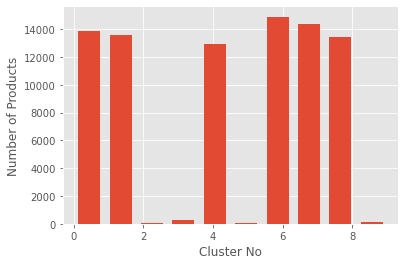

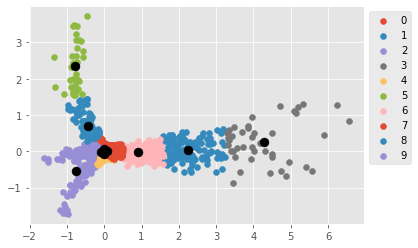

<Figure size 432x288 with 0 Axes>

In [108]:
model = fit_kmeans()


In [109]:
def save_final_product_clusters():
  import numpy as np  
  array_product_vectors = np.array(product_ids_and_vectors["Vectors"].values.tolist())

  assigned_cluster_no = model.fit_predict(array_product_vectors).tolist()

  product_ids_and_vectors["Cluster_No"] = assigned_cluster_no
  cluster_members_df = product_ids_and_vectors[["Product_ID","Cluster_No"]].groupby("Cluster_No")['Product_ID'].apply(list).to_frame().reset_index().rename(columns={'Product_ID': 'Cluster_Member_List'})

  return cluster_members_df

In [110]:
cluster_members_df = save_final_product_clusters()
cluster_members_df.head(10)

,Cluster_No,Cluster_Member_List
0,0,"[842157357, 319019253, 337337465, 662375153, 5..."
1,1,"[699866893, 598552791, 687352899, 620517387, 5..."
2,2,"[752126531, a521829648, 521829326, a575060958,..."
3,3,"[337340793, 337326665, a652976204, 375324813, ..."
4,4,"[242438430, 222487230, 48592580, 726622075, 34..."
5,5,"[491730857, 699079214, 103709707, 652681942, 5..."
6,6,"[380040945, 62932867, 652976667, 606889615, 68..."
7,7,"[652695598, 14581972, 794591600, 496979374, a6..."
8,8,"[292821487, 113666925, 376670910, 32322582, 63..."
9,9,"[505646701, 760144855, a70606593, 722451850, 1..."


## PART3 - Recommendation

In [119]:
import numpy as np
# Product ID to generate recommendations for
product_id = "63594"

# Get Vector (Embedding) array of the given product
vector_array = np.array(product_ids_and_vectors[product_ids_and_vectors["Product_ID"]==product_id]["Vectors"].tolist())

# Get cluster number for the given product assigned by the model
cluster_no = model.predict(vector_array)[0]


# Get members list of the cluster that the given product is assigned to 
cluster_members_list = cluster_members_df[cluster_members_df['Cluster_No']==cluster_no]['Cluster_Member_List'].iloc[0]

# Randomly select 15 product recommendations from the cluster members excluding the given product
from random import sample
#cluster_members_list.remove(product_id)
five_product_recommendations = sample(cluster_members_list, 15)

print("15 Similar Product Recommendations for {}: ".format('\n' +product_id + '\n'),five_product_recommendations)
#print("15 Similar Product Recommendations for {}: ".format(product_id),cluster_members_list.model)

15 Similar Product Recommendations for 
63594
:  ['483674', '803933280', '111101993', '659911402', '31859206', '620472039', '59898200', '541172987', '485022677', '197613032', '622436565', '41249314', '339146629', '522979456', '435021975']


In [59]:
#veri setindeki benzersiz müşteri sayımız
customers = df["client"].unique().tolist()


27799

In [61]:
# müşteri client Id'lerini karıştırır
random.shuffle(customers)

# müşteri Id'lerinin %90'ını çıkarır.
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# verileri train ve validationa ayırır.
train_df = df[df['client'].isin(customers_train)]
validation_df = df[~df['client'].isin(customers_train)]

In [62]:
# müşterilerin ürün görüntüleme geçmişini yakalamak için liste
purchases_train = []

# listeyi ürün kodlarıyla doldurur
for i in tqdm(customers_train):
    temp = train_df[train_df["client"] == i]["product_id"].tolist()
    purchases_train.append(temp)

100%|██████████| 25019/25019 [17:42<00:00, 23.55it/s]


In [63]:
# validasyon- müşterilerin ürün görüntüleme geçmişini yakalamak için liste
purchases_val = []

# listeyi ürün kodlarıyla doldurur
for i in tqdm(validation_df['client'].unique()):
    temp = validation_df[validation_df["client"] == i]["product_id"].tolist()
    purchases_val.append(temp)

100%|██████████| 2780/2780 [00:16<00:00, 169.74it/s]


In [123]:
# train word2vec model
model =   word2vec.Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)



(1891854, 2914180)

In [124]:
# modeli bellek için daha verimli hale getirir.
model.init_sims(replace=True)

In [125]:
# model özetini verir.
print(model)

Word2Vec<vocab=11177, vector_size=100, alpha=0.03>


In [126]:
# tüm vektörleri çıkarır
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
X.shape


(11177, 100)

In [127]:
products = train_df[["product_id", "client"]]

products.drop_duplicates(inplace=True, subset='product_id', keep="last")

#  product-ID ve product-client dictionary yapısı
products_dict = products.groupby('product_id')['client'].apply(list).to_dict()

In [128]:
# test the dictionary
products_dict['746882']

['0f526a95-cff0-46cc-ad77-906f86ff1e9a']

In [136]:
def similar_products(v, n=15):
    
    # en benzer ürünleri vektörden çıkarmak
    ms = model.wv.most_similar(v, topn= n+1)[1:]
    
    # benzer ürün id'si ve benzerlik skorlarını çıkarmak 
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

#### Test : tek bir ürün vektörüne göre benzer ürün önerme

In [137]:
# tek bir ürün vektörüne göre benzer ürün önerme
model.wv.most_similar('746882')

[('1001335', 0.9742641448974609),
 ('102965772', 0.9410273432731628),
 ('69716997', 0.9402053356170654),
 ('70251457', 0.9347025156021118),
 ('639638', 0.9338933229446411),
 ('973081', 0.9097626209259033),
 ('639637', 0.9081178903579712),
 ('994564', 0.9064275622367859),
 ('880887', 0.9047559499740601),
 ('809402', 0.8542018532752991)]

In [138]:
# geçmiş görüntüleme işlemine göre önerme
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [139]:
# Bir kullanıcı tarafından görüntülenen ürünlerin ilk listesinin uzunluğu
len(purchases_val[0])

12

In [140]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [141]:
# sistemimiz bir kullanıcının tüm görüntüleme geçmişine dayalı olarak 15 ürün önerdi.
similar_products(aggregate_vectors(purchases_val[0]),15)

[('ff31e26a-4fef-425f-97c2-5456f08945fe', 0.9523011445999146),
 ('9cbeb70d-8459-4a3f-ac80-572eac6c6c06', 0.9518357515335083),
 ('e86e8778-d4e6-40ad-972f-6a39aba015f4', 0.89969801902771),
 ('f28730a8-4e36-47c4-a79b-1d2d1b7fe051', 0.8867565989494324),
 ('ae48f5cf-b18e-4b14-ba4f-6b88e700fd4f', 0.8686906695365906),
 ('39356210-5d91-497a-943d-763daaf7172c', 0.8678069710731506),
 ('eda1bea6-9130-463f-a765-fc891ba3f794', 0.8599176406860352),
 ('d7cbbb7d-d78f-4622-be10-b6471e269f57', 0.8591040968894958),
 ('a1f7045a-eb14-4b85-801e-df55fbc31d2f', 0.8570908308029175),
 ('34c4124d-380a-4356-b94c-3f25ff3e9e13', 0.8543232679367065),
 ('a196278e-14e1-4421-b180-b5e024e6dcdf', 0.8514467477798462),
 ('69022a89-3ee8-49b3-8de9-736fd39e4e72', 0.850095272064209),
 ('a5e2050d-bacd-407b-bb4c-d6320abe8488', 0.8495907783508301),
 ('e3f04fa6-516d-44d6-b6ad-d4f43b6542ab', 0.8487294316291809),
 ('38ac5da2-d309-453e-a3e9-8de6c6eb21ef', 0.8485289812088013)]

### BONUS

##### Eğitim verisetinde bulunmayan ürünlerin ayrı bir veri kümesi oluşturularak validasyon veri kümesi şeklinde modelin doğrulaması yapılabilir.
